# DataLab Cup 3: Reverse Image Caption
<hr>

Team Name: 沒liao恩宇

Team Member: 110062560 林子鵑、110062802 呂宸漢、110062552 周伯宇

## Environment Setting

In [1]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2022-12-23 20:40:21.699370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2 Physical GPUs, 1 Logical GPUs


## Utility Function

In [2]:
import numpy as np
import imageio


def make_puzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h: (j + 1) * h, i * w: (i + 1) * w, :] = img
    if path is not None:
        imageio.imwrite(path, out)
    return out


## Parameter Setting

In [3]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

SAMPLE_ROW = 8
SAMPLE_COL = 8
SAMPLE_NUM = SAMPLE_ROW * SAMPLE_COL

hparams = {
    'HIDDEN_DIM': 64,
    'DENSE_DIM': 128,
    'Z_DIM': 100,
    'BATCH_SIZE': 128,
    'LEARNING_RATE': 1e-4,
    'BETA_1': 0.5,
    'BETA_2': 0.999,
    'LAMBDA': 10,
    'NUM_EPOCH': 100,
    'NOISE_DECAY_LIMIT': 30,
    'CHECKPOINTS_DIR': './checkpoints/ckpt/',
    'TRAIN_FROM_LATEST_EPOCH': False,
    'PRINT_FREQ': 10
}


## Preprocess Training Data

In [4]:
dictionary_dir = './dictionary/'
word2Id_dict = dict(np.load(dictionary_dir + 'word2Id.npy'))
id2word_dict = dict(np.load(dictionary_dir + 'id2Word.npy'))


def indices_list_to_text_list(indices_list):
    text_list = []
    for indices in indices_list:
        word_list = []
        for idx in indices:
            if idx == word2Id_dict['<RARE>']:
                continue
            if idx == word2Id_dict['<PAD>']:
                break
            word_list.append(id2word_dict[idx])
        text = ' '.join(word_list)
        if len(text.strip()) != 0:
            text_list.append(text)
    return text_list


### Text Embedding with Sentence-BERT

Install `SentenceTransformer`
```sh
$ conda install -c conda-forge sentence-transformers
$ conda install -c conda-forge ipywidgets
```

In [5]:
from sentence_transformers import SentenceTransformer
import pandas as pd

dataset_dir = './dataset/'
if os.path.exists(dataset_dir + 'train_data_embedding.pkl'):
    df_train = pd.read_pickle(dataset_dir + 'train_data_embedding.pkl')
else:
    sbert = SentenceTransformer('all-mpnet-base-v2')
    df_train = pd.read_pickle(dataset_dir + 'text2ImgData.pkl')
    df_train['Texts'] = df_train['Captions'].apply(lambda x: indices_list_to_text_list(x))
    df_train['Embeddings'] = df_train['Texts'].apply(lambda x: sbert.encode(x))
    df_train.to_pickle(dataset_dir + 'train_data_embedding.pkl')


In [6]:
df_train.head()


,Captions,ImagePath,Texts,Embeddings
ID,,,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,[the petals of the flower are pink in color an...,"[[0.04932529, -0.0877918, -0.0462442, 0.074586..."
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,[this flower has white petals and yellow pisti...,"[[-0.02287831, -0.027273156, -0.019405482, 0.0..."
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,[the petals on this flower are pink with white...,"[[0.0042607994, -0.022952529, -0.043796103, 0...."
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,[the flower has a smooth purple petal with whi...,"[[0.03580964, -0.020764414, -0.037616376, 0.06..."
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,[this white flower has bright yellow stamen wi...,"[[-0.014632301, -0.07224098, -0.046013925, 0.0..."


## Create Training Dataset

In [7]:
import random


def map_train(embedding, image_path):
    embedding = tf.cast(embedding, tf.float32)

    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=IMAGE_CHANNEL)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, IMAGE_CHANNEL])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])

    if tf.random.uniform([]) < 0.25:
        img = tf.image.flip_left_right(img)
    if tf.random.uniform([]) < 0.25:
        img = tf.image.random_brightness(img, max_delta=0.2)
    img = img * 2 - 1

    return embedding, img


def train_dataset_generator(embedding_array, image_path_array, batch_size):
    embedding_list = []
    image_path_list = []
    for embeddings, image_path in zip(embedding_array, image_path_array):
        for embedding in embeddings:
            embedding_list.append(embedding)
            image_path_list.append(image_path)

    dataset = tf.data.Dataset.from_tensor_slices((embedding_list, image_path_list))
    dataset = dataset.map(map_train, tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(embedding_list))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [8]:
dataset_train = train_dataset_generator(df_train['Embeddings'].values, df_train['ImagePath'].values, hparams['BATCH_SIZE'])
print(f'There are {len(dataset_train) * hparams["BATCH_SIZE"]:d} samples in training data.')


There are 70400 samples in training data.


## Conditional GAN Model (DCGAN)

In [9]:
conv_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
batchnorm_init = tf.keras.initializers.RandomNormal(mean=1.0, stddev=0.02)


### Generator

In [10]:
def deconv_batchnorm_relu(filters):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=5,
            strides=2,
            padding='SAME',
            output_padding=1,
            use_bias=False,
            kernel_initializer=conv_init
        ),
        tf.keras.layers.BatchNormalization(gamma_initializer=batchnorm_init),
        tf.keras.layers.ReLU()
    ])


class Generator(tf.keras.Model):
    def __init__(self, hparams):
        super(Generator, self).__init__()
        self.hparams = hparams
        self.dim = self.hparams['HIDDEN_DIM']

        self.embedding_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.hparams['DENSE_DIM']),
            tf.keras.layers.LeakyReLU(0.2)
        ])

        self.concat_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.dim * 8 * 4 * 4, use_bias=False),
            tf.keras.layers.BatchNormalization(gamma_initializer=batchnorm_init),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Reshape([4, 4, -1]),

            deconv_batchnorm_relu(self.dim * 4),
            deconv_batchnorm_relu(self.dim * 2),
            deconv_batchnorm_relu(self.dim * 1),
            tf.keras.layers.Conv2DTranspose(
                filters=IMAGE_CHANNEL,
                kernel_size=5,
                strides=2,
                padding='SAME',
                output_padding=1,
                activation=tf.keras.activations.tanh,
                kernel_initializer=conv_init
            )
        ])

    def call(self, embedding, noise_z):
        embedding = self.embedding_layers(embedding)

        concat = tf.concat([noise_z, embedding], axis=1)

        output = self.concat_layers(concat)

        return output


### Discriminator

In [11]:
def conv_batchnorm_leaky_relu(filters):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=5,
            strides=2,
            padding='SAME',
            kernel_initializer=conv_init
        ),
        tf.keras.layers.BatchNormalization(gamma_initializer=batchnorm_init),
        tf.keras.layers.LeakyReLU(0.2)
    ])


class Discriminator(tf.keras.Model):
    def __init__(self, hparams):
        super(Discriminator, self).__init__()
        self.hparams = hparams
        self.dim = self.hparams['HIDDEN_DIM']

        self.embedding_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.hparams['DENSE_DIM']),
            tf.keras.layers.LeakyReLU(0.2)
        ])

        self.image_layers = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                filters=self.dim,
                kernel_size=5,
                strides=2,
                padding='SAME',
                kernel_initializer=conv_init
            ),
            tf.keras.layers.LeakyReLU(0.2),
            conv_batchnorm_leaky_relu(self.dim * 2),
            conv_batchnorm_leaky_relu(self.dim * 4),
            conv_batchnorm_leaky_relu(self.dim * 8)
        ])

        self.concat_layers = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                filters=self.dim * 8,
                kernel_size=1,
                strides=1,
                padding='SAME',
                kernel_initializer=conv_init
            ),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Conv2D(
                filters=1,
                kernel_size=4,
                strides=1,
                padding='VALID',
                kernel_initializer=conv_init
            ),
            tf.keras.layers.Reshape([])
        ])

    def call(self, embedding, image):
        embedding = self.embedding_layers(embedding)
        embedding = tf.expand_dims(embedding, axis=1)
        embedding = tf.expand_dims(embedding, axis=1)
        embedding = tf.tile(embedding, multiples=[1, 4, 4, 1])

        image = self.image_layers(image)

        concat = tf.concat([image, embedding], axis=-1)

        output = self.concat_layers(concat)

        return output


In [12]:
generator = Generator(hparams)
discriminator = Discriminator(hparams)


### Optimizer and Loss Function

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(hparams['LEARNING_RATE'], hparams['BETA_1'], hparams['BETA_2'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparams['LEARNING_RATE'], hparams['BETA_1'], hparams['BETA_2'])


In [14]:
@tf.function
def G_train_step(embedding, real_data, noise_decay):
    noise_z = tf.random.normal([hparams['BATCH_SIZE'], hparams['Z_DIM']])

    with tf.GradientTape() as tape:
        fake_data = generator(embedding, noise_z, training=True)
        fake_data = fake_data + noise_decay * tf.random.normal(fake_data.shape)
        real_data = real_data + noise_decay * tf.random.normal(real_data.shape)

        D_fake = discriminator(embedding, fake_data, training=True)
        D_real = discriminator(embedding, real_data, training=True)

        loss_g = tf.reduce_mean(-D_fake)

        epsilon = tf.random.uniform([hparams['BATCH_SIZE'], 1, 1, 1])
        interpolates = epsilon * real_data + (1 - epsilon) * fake_data
        interpolates = interpolates + noise_decay * tf.random.normal(interpolates.shape)
        slopes = tf.gradients(discriminator(embedding, interpolates, training=True), interpolates)[0]
        l2_norm = tf.sqrt(tf.reduce_sum(slopes ** 2, axis=[1, 2, 3]))
        gradient_penalty = (l2_norm - 1.) ** 2

        loss_d = tf.reduce_mean(D_fake - D_real + hparams['LAMBDA'] * gradient_penalty)

    gradient = tape.gradient(loss_g, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradient, generator.trainable_variables))

    return loss_g, loss_d


@tf.function
def D_train_step(embedding, real_data, noise_decay):
    noise_z = tf.random.normal([hparams['BATCH_SIZE'], hparams['Z_DIM']])

    with tf.GradientTape() as tape:
        fake_data = generator(embedding, noise_z, training=True)
        fake_data = fake_data + noise_decay * tf.random.normal(fake_data.shape)
        real_data = real_data + noise_decay * tf.random.normal(real_data.shape)

        D_fake = discriminator(embedding, fake_data, training=True)
        D_real = discriminator(embedding, real_data, training=True)

        loss_g = tf.reduce_mean(-D_fake)

        epsilon = tf.random.uniform([hparams['BATCH_SIZE'], 1, 1, 1])
        interpolates = epsilon * real_data + (1 - epsilon) * fake_data
        interpolates = interpolates + noise_decay * tf.random.normal(interpolates.shape)
        slopes = tf.gradients(discriminator(embedding, interpolates, training=True), interpolates)[0]
        l2_norm = tf.sqrt(tf.reduce_sum(slopes ** 2, axis=[1, 2, 3]))
        gradient_penalty = (l2_norm - 1.) ** 2

        loss_d = tf.reduce_mean(D_fake - D_real + hparams['LAMBDA'] * gradient_penalty)

    gradient = tape.gradient(loss_d, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradient, discriminator.trainable_variables))

    return loss_g, loss_d


In [15]:
train_step = (
    D_train_step,
    D_train_step,
    G_train_step
)

num_critic = len(train_step)


## Choose Training Sample for Validation

In [16]:
samples_dir = './samples/'
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)


In [17]:
sample_embeddings = []
for embeddings in df_train['Embeddings'].values:
    if len(embeddings) >= SAMPLE_ROW:
        for j in range(SAMPLE_ROW):
            sample_embeddings.append(embeddings[j])
    if len(sample_embeddings) == SAMPLE_NUM:
        break

sample_embeddings = tf.Variable(sample_embeddings)
print(sample_embeddings.shape)


(64, 768)


## Training

In [18]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, hparams['CHECKPOINTS_DIR'], max_to_keep=20)

start_epoch = 0
if hparams['TRAIN_FROM_LATEST_EPOCH'] and checkpoint_manager.latest_checkpoint:
    start_epoch = int(checkpoint_manager.latest_checkpoint.split('-')[-1])
    checkpoint.restore(checkpoint_manager.latest_checkpoint)


In [19]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt


def train(start_epoch, stop_epoch):
    g_loss_list = [None] * (stop_epoch - start_epoch)
    d_loss_list = [None] * (stop_epoch - start_epoch)

    critic = 0
    num_train_step = len(dataset_train)
    sample_noise = tf.random.normal([SAMPLE_NUM, hparams['Z_DIM']])

    pbar = trange(start_epoch, stop_epoch, unit='epoch')
    for epoch in pbar:
        loss_g_t = 0.0
        loss_d_t = 0.0

        if epoch < hparams['NOISE_DECAY_LIMIT']:
            noise_decay = 1 / (epoch + 1)
        else:
            noise_decay = 0

        for embedding, real_data in dataset_train:
            loss_g, loss_d = train_step[critic](embedding, real_data, noise_decay)
            critic = critic + 1 if critic + 1 < num_critic else 0
            loss_g_t += loss_g.numpy()
            loss_d_t += loss_d.numpy()

        g_loss_list[epoch] = loss_g_t / num_train_step
        d_loss_list[epoch] = loss_d_t / num_train_step
        pbar.set_postfix({'g_loss': loss_g_t / num_train_step, 'd_loss': loss_d_t / num_train_step})

        out = generator(sample_embeddings, sample_noise, training=False)
        img = make_puzzle(
            ((out + 1) / 2 * 255).numpy().astype(np.uint8),
            SAMPLE_ROW,
            SAMPLE_COL,
            f'{samples_dir}train_{epoch + 1:04d}.png'
        )
        if (epoch + 1) % hparams['PRINT_FREQ'] == 0:
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Epoch {epoch + 1:d}')
            plt.show()

        checkpoint_manager.save(epoch + 1)

    return g_loss_list, d_loss_list


  0%|          | 0/100 [00:00<?, ?epoch/s]/home/ericlu1218/anaconda3/envs/dl/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
  9%|▉         | 9/100 [10:10<1:31:50, 60.56s/epoch, g_loss=59.4, d_loss=-6.32]

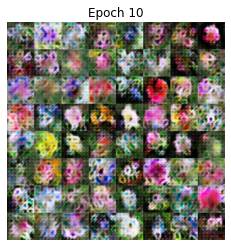

 19%|█▉        | 19/100 [25:07<1:59:45, 88.71s/epoch, g_loss=59.2, d_loss=-6.53]

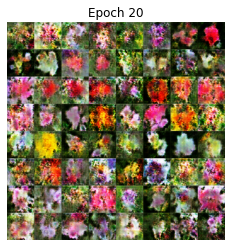

 29%|██▉       | 29/100 [37:55<1:38:22, 83.14s/epoch, g_loss=96.8, d_loss=-2.03]

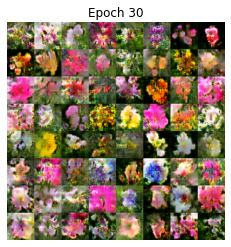

 39%|███▉      | 39/100 [51:08<1:14:07, 72.90s/epoch, g_loss=132, d_loss=-6.26] 

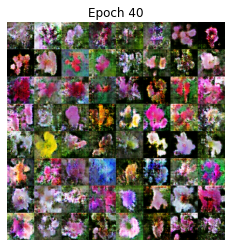

 49%|████▉     | 49/100 [1:00:52<49:51, 58.65s/epoch, g_loss=156, d_loss=-3.38]

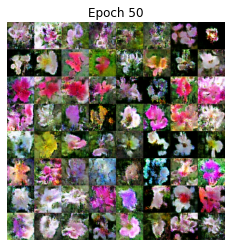

 59%|█████▉    | 59/100 [1:10:37<39:50, 58.31s/epoch, g_loss=169, d_loss=-4.22]

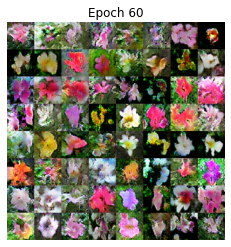

 69%|██████▉   | 69/100 [1:20:32<30:54, 59.82s/epoch, g_loss=215, d_loss=-7.37]

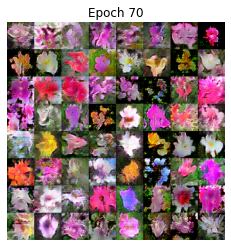

 79%|███████▉  | 79/100 [1:30:23<20:35, 58.84s/epoch, g_loss=217, d_loss=-2.48]

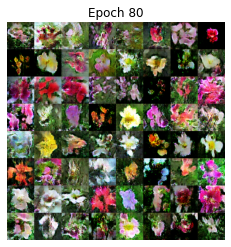

 89%|████████▉ | 89/100 [1:40:07<10:41, 58.34s/epoch, g_loss=276, d_loss=5.14] 

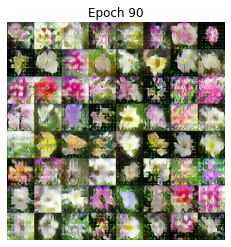

 99%|█████████▉| 99/100 [1:50:01<00:59, 59.35s/epoch, g_loss=245, d_loss=-8.1] 

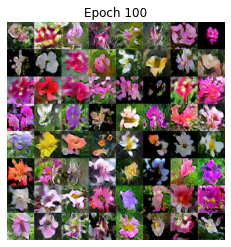

100%|██████████| 100/100 [1:50:02<00:00, 66.02s/epoch, g_loss=245, d_loss=-8.1]


In [20]:
g_loss_list, d_loss_list = train(start_epoch, hparams['NUM_EPOCH'])


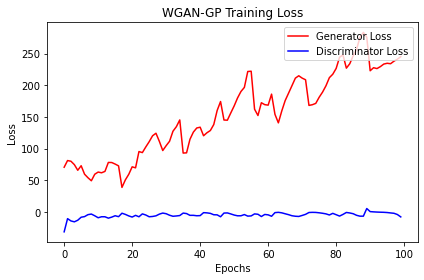

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(start_epoch, hparams['NUM_EPOCH']), g_loss_list, color='red', label='Generator Loss')
plt.plot(range(start_epoch, hparams['NUM_EPOCH']), d_loss_list, color='blue', label='Discriminator Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('WGAN-GP Training Loss')
plt.tight_layout()
plt.show()


# Evaluation

## Preprocess Testing Data

In [22]:
from sentence_transformers import SentenceTransformer
import pandas as pd

if os.path.exists(dataset_dir + 'test_data_embedding.pkl'):
    df_test = pd.read_pickle(dataset_dir + 'test_data_embedding.pkl')
else:
    sbert = SentenceTransformer('all-mpnet-base-v2')
    df_test = pd.read_pickle(dataset_dir + 'testData.pkl')
    df_test['Texts'] = df_test['Captions'].apply(lambda x: indices_list_to_text_list([x]))
    df_test['Embeddings'] = df_test['Texts'].apply(lambda x: sbert.encode(x)[0])
    df_test.to_pickle(dataset_dir + 'test_data_embedding.pkl')


In [23]:
df_test.head()


,ID,Captions,Texts,Embeddings
0,6735,"[4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427, ...",[this white and purple flower has fragile peta...,"[-0.019418148, 0.009196017, -0.035796143, 0.01..."
1,6740,"[4, 1, 5, 158, 26, 64, 14, 2, 7, 12, 160, 3, 6...",[this flower has four large wide pink petals w...,"[-0.0006797304, -0.024217857, -0.037336938, 0...."
2,6746,"[8, 1, 7, 157, 12, 3, 14, 454, 2, 3, 11, 19, 5...",[a flower with broad white and pink ribbed pet...,"[0.005095658, -0.035780836, -0.037371118, 0.01..."
3,6759,"[91, 1643, 31, 7, 2369, 2370, 3, 45, 59, 7, 56...",[one prominet pistil with alarger stigam and m...,"[0.001740396, -0.05631346, -0.0151782455, 0.03..."
4,6762,"[53, 6, 21, 13, 18, 2, 6, 34, 14, 13, 18, 5427...",[leaves are green in color petals are light pi...,"[0.006606216, -0.03073213, -0.040895294, 0.074..."


## Create Testing Dataset

In [24]:
def map_test(embedding, index):
    embedding = tf.cast(embedding, tf.float32)
    return embedding, index


def test_dataset_generator(embedding_array, index_array, batch_size):
    embedding_list = []
    index_list = []
    for embedding, index in zip(embedding_array, index_array):
        embedding_list.append(embedding)
        index_list.append(index)

    dataset = tf.data.Dataset.from_tensor_slices((embedding_list, index_list))
    dataset = dataset.map(map_test, tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)

    return dataset


In [25]:
dataset_test = test_dataset_generator(df_test['Embeddings'].values, df_test['ID'].values, hparams['BATCH_SIZE'])
print(f'There are {len(df_test):d} samples in testing dataset.')


There are 819 samples in testing dataset.


## Inference

In [26]:
inference_dir = './inference/'
if not os.path.exists(inference_dir):
    os.makedirs(inference_dir)


In [27]:
@tf.function
def test_step(embedding, noise):
    fake_image = generator(embedding, noise, training=False)
    return fake_image


In [28]:
checkpoint.restore(checkpoint_manager.latest_checkpoint)


In [29]:
import time


def inference():
    num_test_step = len(df_test) // hparams['BATCH_SIZE']
    sample_noise = np.random.normal(loc=0.0, scale=1.0, size=(hparams['Z_DIM'])).astype(np.float32)
    sample_noise = np.tile(sample_noise, (hparams['BATCH_SIZE'], 1))

    step = 0
    start = time.time()
    for embedding, index in dataset_test:
        fake_image = test_step(embedding, sample_noise)
        for i in range(hparams['BATCH_SIZE']):
            plt.imsave(f'{inference_dir}inference_{index[i]:04d}.jpg', (fake_image[i].numpy() + 1) / 2)

        step += 1
        if step > num_test_step:
            break

    print('Time for inference is {:.4f} sec'.format(time.time()-start))


In [30]:
inference()


Time for inference is 0.9686 sec


## Inception Score & Cosine Similarity

**Clear GPU memory to avoid OOM!**

Install `numba`
```sh
$ conda install -c numba numba
```

In [31]:
from numba import cuda

cuda.get_current_device().reset()


In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
score_file = './score.csv'
if os.path.exists(score_file):
    os.remove(score_file)


In [33]:
%cd testing
!python inception_score_debug.py ../inference/ ../score.csv 39
%cd ..


/home/ericlu1218/DL/Comp03/testing
2 Physical GPUs, 1 Logical GPUs
--------------Evaluation Success-----------------
/home/ericlu1218/DL/Comp03


In [34]:
import os
import pandas as pd
import numpy as np

if os.path.exists(score_file):
    df_score = pd.read_csv(score_file)
    mean_score = np.mean(df_score['score'].values)
    print(f'Mean Score: {mean_score:f}')
else:
    print('Evaluation Failed!')


Mean Score: 0.475582
